In [1]:
# Add src module directory to system path for subsecuent imports.
import os
import sys
sys.path.insert(0, '../src')

In [2]:
from util import is_notebook

# Settings (only in Jupyter Notebooks).
if is_notebook():
    # Module reloading.
    %load_ext autoreload
    # aimport?
    %autoreload 2
    # Plot settings.
    %matplotlib inline

In [3]:
# Imports.
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader
from datasets import load_metric

from constants import *
from util import *
from transformer import Transformer
from tokenizer import load_tokenizer
from data import download_data, load_data
from plotting import plot_metric
from metric_logging import MetricLogger

In [4]:
# Set seed.
from pytorch_lightning import seed_everything
seed_everything(0, workers=True)

Global seed set to 0


0

In [5]:
# Experiment paramereters.
hparams = dotdict({
    'src_lang': 'de',
    'pvt_lang': 'nl',
    'tgt_lang': 'en',
    'src_pvt_model_path': 'models/baseline-de-nl.pt',
    'pvt_tgt_model_path': 'models/baseline-nl-en.pt',
    'batch_size': 80,
    'max_epochs': 10,
    'max_examples': 10_000,
    'gpus': 1,
    'num_workers': 4,
    'ckpt_path': None,
})

print('Experiment paramereters:')
print(hparams)

Experiment paramereters:
{'src_lang': 'de', 'pvt_lang': 'nl', 'tgt_lang': 'en', 'src_pvt_model_path': 'models/baseline-de-nl.pt', 'pvt_tgt_model_path': 'models/baseline-nl-en.pt', 'batch_size': 80, 'max_epochs': 10, 'max_examples': -1, 'gpus': 1, 'num_workers': 4, 'ckpt_path': None}


In [6]:
# Constant directories.
data_dir = os.path.join('./', 'data')
tokenizers_dir = os.path.join('./', 'tokenizers')
runs_dir = os.path.join('./', 'runs')

# Experiment directories.
run_dir = os.path.join(runs_dir, f'direct-pivoting-{hparams.src_lang}-{hparams.pvt_lang}-{hparams.tgt_lang}-{get_time_as_string()}')
model_checkpoints_dir = os.path.join(run_dir, 'checkpoints')
results_dir = os.path.join(run_dir, 'results')
pre_training_eval_results_dir = os.path.join(run_dir, 'pre-training-eval-results')

dirs = [data_dir, tokenizers_dir, runs_dir, run_dir, model_checkpoints_dir, results_dir, pre_training_eval_results_dir]
for dir in dirs:
    create_dir(dir)

print('Created directories.')

Dir "./data" already exists.
Dir "./runs" already exists.
Dir "./runs\direct-pivoting-de-nl-en-2022.09.15-16.53.59" does not exist, creating it.
Dir "./runs\direct-pivoting-de-nl-en-2022.09.15-16.53.59\checkpoints" does not exist, creating it.
Dir "./runs\direct-pivoting-de-nl-en-2022.09.15-16.53.59\results" does not exist, creating it.
Dir "./runs\direct-pivoting-de-nl-en-2022.09.15-16.53.59\pre-training-eval-results" does not exist, creating it.
Created directories.


In [7]:
# Load Metrics.
score_metric = load_metric('sacrebleu')

print('Loaded metrics.')

Loaded metrics.


In [8]:
# Download data.
download_data(hparams.src_lang, hparams.tgt_lang)

File "data\de-en.zip" already exists. Skipping download.
Directory data\de-en already exists. Skipping unzipping.


In [9]:
# Load tokenizers.
src_tokenizer = load_tokenizer(hparams.src_lang, hparams.tgt_lang)
pvt_tokenizer = load_tokenizer(hparams.pvt_lang, hparams.tgt_lang)
tgt_tokenizer = load_tokenizer(hparams.tgt_lang, hparams.src_lang)

print('Loaded tokenizers.')

Tokenizer exists. Skipping training.
Tokenizer exists. Skipping training.
Tokenizer exists. Skipping training.
Loaded tokenizers.


In [10]:
# Load data.
train_dataset, val_dataset, test_dataset = load_data(hparams.src_lang,
                                                     hparams.tgt_lang,
                                                     src_tokenizer,
                                                     tgt_tokenizer,
                                                     hparams.max_examples)

print(f'Preprocessed data ({hparams.src_lang}-{hparams.tgt_lang})')
print(f'\tTraining data:   {len(train_dataset)}')
print(f'\tValidation data: {len(val_dataset)}')
print(f'\tTest data:       {len(test_dataset)}')

Preprocessed data exists, loading from disk...
Splitting de-en data...
Data (de-en) split.
Preprocessed data (de-en)
	Training data:   1416094
	Validation data: 78671
	Test data:       78671


In [11]:
# Create data loaders.
train_dataloader = DataLoader(train_dataset, batch_size=hparams.batch_size, num_workers=hparams.num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=hparams.batch_size, num_workers=hparams.num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=hparams.batch_size, num_workers=hparams.num_workers)

print('Created data loaders.')

Created data loaders.


In [12]:
# Create models.
src_pvt_model = Transformer(src_tokenizer,
                            pvt_tokenizer,
                            score_metric=score_metric)

pvt_tgt_model = Transformer(pvt_tokenizer,
                            tgt_tokenizer,
                            score_metric=score_metric)

print('Created models.')

Created models.


In [13]:
# Load models.
src_pvt_model.load_state_dict(torch.load(hparams.src_pvt_model_path))
pvt_tgt_model.load_state_dict(torch.load(hparams.pvt_tgt_model_path))

src_pvt_model.to(device)
pvt_tgt_model.to(device)

print('Loaded models.')

Loaded models.


In [14]:
# Create direct pivoting model.
model = pvt_tgt_model
model.src_tokenizer = src_tokenizer
model.src_vocab_size = src_pvt_model.src_vocab_size
model.src_embedding = src_pvt_model.src_embedding
model.encoder = src_pvt_model.encoder

In [15]:
# Add aditional regularization to combat over-fitting on limited data.
model.set_dropout_rate(0.3)
model.weight_decay = 0.0

In [16]:
# Create trainer.
metric_logger = MetricLogger()
checkpoint_callback = pl.callbacks.ModelCheckpoint(
          dirpath=model_checkpoints_dir,
          verbose=True,
          save_last=True,
      )

trainer = Trainer(deterministic=True,
                  fast_dev_run=False,
                  max_epochs=hparams.max_epochs,
                  logger=metric_logger,
                  log_every_n_steps=1,
                  enable_checkpointing=True,
                  default_root_dir=model_checkpoints_dir,
                  callbacks=[checkpoint_callback],
                  gpus=hparams.gpus if str(device) == 'cuda' else 0)

print('Created trainer.')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).
`Trainer(limit_train_batches=1)` was configured so 1 batch per epoch will be used.
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_test_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_predict_batches=1)` was configured so 1 batch will be used.
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


Created trainer.


In [17]:
# Save untrained model.
model_path = os.path.join(pre_training_eval_results_dir, 'model.pt')
torch.save(model.state_dict(), model_path)

In [18]:
# Evaluate performance.
test_metrics = trainer.test(model, dataloaders=test_dataloader)
print(test_metrics)
metric_logger.manual_save(pre_training_eval_results_dir)
metric_logger.reset()

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        1.2056682109832764
    test_score_epoch        0.7950282692909241
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[{'test_loss_epoch': 1.2056682109832764, 'test_score_epoch': 0.7950282692909241}]


In [19]:
# Training.
trainer.fit(model,
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader)


  | Name               | Type              | Params
---------------------------------------------------------
0 | src_embedding      | Embedding         | 8.2 M 
1 | tgt_embedding      | Embedding         | 8.2 M 
2 | positional_encoder | PositionalEncoder | 0     
3 | encoder            | Encoder           | 18.9 M
4 | decoder            | Decoder           | 25.2 M
5 | output_linear      | Linear            | 8.2 M 
6 | softmax            | LogSoftmax        | 0     
---------------------------------------------------------
68.7 M    Trainable params
0         Non-trainable params
68.7 M    Total params
274.930   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [20]:
# Save model.
model_path = os.path.join(run_dir, 'model.pt')
torch.save(model.state_dict(), model_path)

In [21]:
# Testing.
test_metrics = trainer.test(model, dataloaders=test_dataloader)
print(test_metrics)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        1.1716341972351074
    test_score_epoch        0.8549150228500366
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[{'test_loss_epoch': 1.1716341972351074, 'test_score_epoch': 0.8549150228500366}]


IndexError: list index out of range

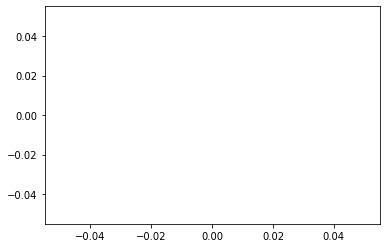

In [22]:
# Plot loss metrics.
save_path = os.path.join(results_dir, 'loss.svg')
plot_metric(metric_logger.metrics, 'loss', 'Loss', save_path=save_path)

In [ ]:
# Plot score metric.
save_path = os.path.join(results_dir, 'score.svg')
plot_metric(metric_logger.metrics, 'score', 'Score', save_path=save_path)

In [ ]:
# Save hyper parameters.
save_dict(run_dir, hparams, 'hparams')

In [ ]:
# Save recorded metrics.
metric_logger.manual_save(results_dir)